## FIN42120 Programming for Financial Data Science

### Group Project

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import t
import statsmodels.api as sm
import collections
from sklearn.metrics import mean_squared_error

from utils import *

import matplotlib.pyplot as plt
plt.style.use('ggplot') # fivethirtyeight, ggplot, dark_background, classic,  
import warnings
warnings.filterwarnings("ignore")

---

    Q1. Download monthly prices of the S&P 500 stock market index (SP500) from the website of the U.S. Federal Reserve Economic Data (https://fred.stlouisfed.org/) or Bloomberg and the Bloomberg Barclays U.S. Aggregate Bond Index (LBUSTRUU) from Blomberg for the period from December 1979 to December 2021. Download monthly data on the risk-free rate of return (among the so-called Fama and French factors) for the same period from Professor Kenneth French’s data library at http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html.
    
    Write a Python function to compute the following statistics for U.S. stock and bond simple excess returns:
    (a) annualized mean/average
    (b) annualized volatility
    (c) annualized Sharpe ratio
    (d) skewness
    (e) kurtosis
    
    Report the summary statistics in a table and explain the results.

In [2]:
# fetch market data for all asset classes & predictors needed for forecasting
sp500_full_df, bond_full_df, rf_ret_df, predictors_df = get_market_data()
# define a breakpoint to split the data into in-sample and out-of-sample datasets 
breakpoint = dt.datetime(2000, 1, 1)
asset_tickers = ['SP500', 'LBUSTRUU'] # define asset tickers list
# compute simple & excess return for both the asset classes
simp_ret_df = generate_asset_simple_rets(sp500_full_df, bond_full_df, rf_ret_df)
# Generate summary statistics on excess return data for both the asset classes
sp_mean, sp_vol, sp_sharpe, sp_skew, sp_kurt = compute_stat_measures(simp_ret_df['SP500_excess'].values)
bond_mean, bond_vol, bond_sharpe, bond_skew, bond_kurt = compute_stat_measures(simp_ret_df['LBUSTRUU_excess'].values)
asset_ret_summary_stats = pd.DataFrame({'SP500': [sp_mean, sp_vol, sp_sharpe, sp_skew, sp_kurt], 
                                        'LBUSTRUU': [bond_mean, bond_vol, bond_sharpe, bond_skew, bond_kurt]}, 
                                        index=['Mean', 'Volatility', 'Sharpe', 'Skew', 'Kurtosis'])
print('Asset class excess return summary statistics (total time period)')
print('-' * 100)
asset_ret_summary_stats

Asset class excess return summary statistics (total time period)
----------------------------------------------------------------------------------------------------


,SP500,LBUSTRUU
Mean,0.062294,0.032172
Volatility,0.150755,0.051107
Sharpe,0.413216,0.629497
Skew,-0.632931,0.420890
Kurtosis,5.084584,9.168519


---

    Q2. Divide the total sample into two periods: an in-sample from January 1980-December 1999 and an out-of-sample period from January 2000-December 2021. Using a recursive estimate approach, generate a time-series of monthly out-of-sample constant expected (mean) excess return forecasts (call it the mean benchmark forecast) for each of the two asset classes. Write a function to do this computation.

In [3]:
mean_benchmark_forecasts_df = generate_mean_benchmark_forecast(excess_ret=simp_ret_df.loc[:, ['SP500_excess', 'LBUSTRUU_excess']], breakpoint=breakpoint)
print('Out-of-sample Mean Benchmark forecasts')
print('-' * 100)
mean_benchmark_forecasts_df

Out-of-sample Mean Benchmark forecasts
----------------------------------------------------------------------------------------------------


,SP500_MB,LBUSTRUU_MB
Date,,
2000-01-31,0.006309,0.002610
2000-02-29,0.006054,0.002568
2000-03-31,0.005928,0.002590
2000-04-28,0.006283,0.002614
2000-05-31,0.006112,0.002573
...,...,...
2021-08-31,0.005071,0.002729
2021-09-30,0.005119,0.002720
2021-10-29,0.005014,0.002697


---

    Q3. Download monthly data for five variables that you believe are plausible predictors (see, for example, Rapach, Ringgenberg, and Zhou, 2016 for stocks, Lin, Wu, and Zhou, 2017, and the references therein for inspiration) of the asset class excess returns. Based on each of your five predictors and using the same recursive estimation approach, generate monthly out-of-sample excess return forecasts for each of the asset classes using the following three predictive models:

    (i) an OLS predictive regression model for each of the five predictors
    (ii) a combination forecasts of excess returns that is a simple averages of the forecasts based on the five predictors from the OLS model
    (iii) any 2 penalized linear regressions

    The above leads to a total of 8 predictive model forecasts each for stock and bonds. Compute the mean squared forecast error (MSFE) for the benchmark forecast and the ratio of MSFEs for the forecasts of the models relative to the mean benchmark forecast MSFE. Compare the performance of the predictive model forecasts relative to the mean benchmark forecasts using the Diebold and Mariano (1995) test for equal predictive ability (you should write your own function to perform this test). You should clearly state the null hypothesis being tested and also provide a discussion of your table of results. In addition, create a figure showing the time-series of the mean benchmark, combination, and two penalized linear regression excess return forecasts for each of the two asset classes.

In [4]:
# SP500 predictors
sp500_predictors = predictors_df.loc[:, ['infl', 'b/m', 'svar', 'ntis']]
sp500_predictors['div_payout'] = np.log(predictors_df['D12']/predictors_df['E12'])

# Bond predictors
bond_predictors = predictors_df.loc[:, ['infl', 'tbl', 'lty', 'ltr']]
bond_predictors['DFY'] = predictors_df['BAA'] - predictors_df['AAA']

# out-of-sample return forecasts for SP500 predicted using OLS fit on 5 different predictors
sp500_ols_forecasts_df = generate_ols_predictor_forecast(asset_excess_ret=simp_ret_df.loc[:, ['SP500_excess']], predictors=sp500_predictors,
                                                         breakpoint=breakpoint)
# out-of-sample return forecasts for bonds predicted using OLS fit on 5 different predictors 
bond_ols_forecasts_df = generate_ols_predictor_forecast(asset_excess_ret=simp_ret_df.loc[:, ['LBUSTRUU_excess']], predictors=bond_predictors,
                                                        breakpoint=breakpoint)
# Rename the columns in each data frame
sp500_ols_forecasts_df.columns = pd.MultiIndex.from_product([[asset_tickers[0]], sp500_ols_forecasts_df.columns])
bond_ols_forecasts_df.columns = pd.MultiIndex.from_product([[asset_tickers[1]], bond_ols_forecasts_df.columns])
# Concatenate the data frames along the columns axis and create a multi-level column index
ols_predictor_forecasts_df = pd.concat([sp500_ols_forecasts_df, bond_ols_forecasts_df], axis=1)
print('Out-of-sample OLS Predictor forecasts')
print('-' * 100)
ols_predictor_forecasts_df

Out-of-sample OLS Predictor forecasts
----------------------------------------------------------------------------------------------------


SP500                                           LBUSTRUU  \
                infl       b/m      svar      ntis div_payout      infl   
Date                                                                      
2000-01-31  0.014931  0.010115  0.006854  0.004682   0.009748  0.004449   
2000-02-29  0.006675  0.009319  0.003423  0.002816   0.008775  0.002892   
2000-03-31 -0.001008  0.008844  0.005012  0.002196   0.008285  0.001471   
2000-04-28 -0.005992  0.009870  0.002513  0.004658   0.010096  0.000410   
2000-05-31  0.012785  0.009362  0.001182  0.005764   0.009226  0.004099   
...              ...       ...       ...       ...        ...       ...   
2021-08-31  0.003473  0.005018  0.005385  0.004745   0.004340  0.001910   
2021-09-30  0.005351  0.005107  0.005572  0.004834   0.004352  0.002997   
2021-10-29  0.004818  0.004913  0.005251  0.004680   0.004118  0.002714   
2021-11-30  0.001303  0.005145  0.005447  0.004892   0.004260  0.000474   
2021-12-31  0.003474  0.005093  0.005373  0.004821   0.004129  0.001841   

                                                    
                 tbl       lty       ltr       DFY  
Date                                                
2000-01-31  0.002265  0.001008  0.000376  0.002052  
2000-02-29  0.002251  0.000808  0.004093  0.001833  
2000-03-31  0.002353  0.000693  0.004465  0.001982  
2000-04-28  0.002427  0.000526  0.005504  0.002154  
2000-05-31  0.002371  0.000552  0.001097  0.002191  
...              ...       ...       ...       ...  
2021-08-31  0.002482  0.001489  0.004310  0.001847  
2021-09-30  0.002462  0.001455  0.002082  0.001881  
2021-10-29  0.002411  0.001413  0.000656  0.001868  
2021-11-30  0.002399  0.001462  0.002617  0.001789  
2021-12-31  0.002402  0.001465  0.003655  0.001769  

[264 rows x 10 columns]

In [5]:
# Compute Combination mean forecasts
combination_mean_forecasts_df = generate_combination_mean_forecasts(asset1_pred_forecasts=sp500_ols_forecasts_df, 
                                                                    asset2_pred_forecasts=bond_ols_forecasts_df,
                                                                    assets_names=asset_tickers)
print('Out-of-sample Combination Mean forecasts')
print('-' * 100)
combination_mean_forecasts_df

Out-of-sample Combination Mean forecasts
----------------------------------------------------------------------------------------------------


,SP500_Comb_Mean,LBUSTRUU_Comb_Mean
Date,,
2000-01-31,0.009266,0.002030
2000-02-29,0.006202,0.002375
2000-03-31,0.004666,0.002193
2000-04-28,0.004229,0.002204
2000-05-31,0.007664,0.002062
...,...,...
2021-08-31,0.004592,0.002408
2021-09-30,0.005043,0.002176
2021-10-29,0.004756,0.001813


In [6]:
# out-of-sample return forecasts for SP500 predicted using PLR fit on predictors
sp500_plr_forecasts_df = generate_plr_forecast(asset_excess_ret=simp_ret_df.loc[:, ['SP500_excess']], predictors=sp500_predictors,
                                                         breakpoint=breakpoint)
# out-of-sample return forecasts for bonds predicted using PLR fit on predictors
bond_plr_forecasts_df = generate_plr_forecast(asset_excess_ret=simp_ret_df.loc[:, ['LBUSTRUU_excess']], predictors=bond_predictors,
                                                        breakpoint=breakpoint)
# Rename the columns in each data frame
sp500_plr_forecasts_df.columns = pd.MultiIndex.from_product([[asset_tickers[0]], sp500_plr_forecasts_df.columns])
bond_plr_forecasts_df.columns = pd.MultiIndex.from_product([[asset_tickers[1]], bond_plr_forecasts_df.columns])
# Concatenate the data frames along the columns axis and create a multi-level column index
plr_predictor_forecasts_df = pd.concat([sp500_plr_forecasts_df, bond_plr_forecasts_df], axis=1)
print('Out-of-sample Penalised Linear Regression forecasts (using all Predictors)')
print('-' * 100)
plr_predictor_forecasts_df

Out-of-sample Penalised Linear Regression forecasts (using all Predictors)
----------------------------------------------------------------------------------------------------


SP500            LBUSTRUU          
               Lasso     Ridge     Lasso     Ridge
Date                                              
2000-01-31  0.015647  0.010238 -0.000028  0.000027
2000-02-29  0.007081  0.009299  0.002547  0.002617
2000-03-31  0.002067  0.008779  0.000017  0.002766
2000-04-28  0.006104  0.010218 -0.001664  0.003378
2000-05-31  0.005933  0.009535  -0.00246  0.000237
...              ...       ...       ...       ...
2021-08-31  0.004982  0.004506  0.001621  0.002874
2021-09-30   0.00503  0.004551 -0.000029  0.001023
2021-10-29  0.004925  0.004278 -0.001427  -0.00018
2021-11-30  0.005053   0.00448  -0.00038  0.001448
2021-12-31  0.005026  0.004346  0.001214   0.00238

[264 rows x 4 columns]

In [7]:
# combine benchamark & all 8 forecast model predictions for each asset
sp500_all_models = pd.concat([mean_benchmark_forecasts_df.loc[:, ['SP500_MB']], sp500_ols_forecasts_df['SP500'], 
                              combination_mean_forecasts_df.loc[:, ['SP500_Comb_Mean']], sp500_plr_forecasts_df['SP500']], axis=1)
sp500_all_models.rename(columns={'SP500_MB': 'Benchmark', 'SP500_Comb_Mean': 'Combination_mean'}, inplace=True)
bond_all_models = pd.concat([mean_benchmark_forecasts_df.loc[:, ['LBUSTRUU_MB']], bond_ols_forecasts_df['LBUSTRUU'], 
                              combination_mean_forecasts_df.loc[:, ['LBUSTRUU_Comb_Mean']], bond_plr_forecasts_df['LBUSTRUU']], axis=1)
bond_all_models.rename(columns={'LBUSTRUU_MB': 'Benchmark', 'LBUSTRUU_Comb_Mean': 'Combination_mean'}, inplace=True)   

# Compute MSFE for all predictive models & corresponding benchmarks for both the assets
msfe_df = pd.DataFrame(index=asset_tickers, columns=['Benchmark', 'OLS_1', 'OLS_2', 'OLS_3', 'OLS_4', 'OLS_5', 'CM', 'PLR_1', 'PLR_2'])
msfe_df.loc[asset_tickers[0]] = [mean_squared_error(simp_ret_df.loc[simp_ret_df.index > breakpoint, ['SP500_excess']], sp500_all_models[x]) 
                        for x in sp500_all_models.columns]
msfe_df.loc[asset_tickers[1]] = [mean_squared_error(simp_ret_df.loc[simp_ret_df.index > breakpoint, ['LBUSTRUU_excess']], bond_all_models[x]) 
                        for x in bond_all_models.columns]
print('MSFE values for all 9 predictive models including benchmark (both asset classes)')
print('-' * 100)
msfe_df

MSFE values for all 9 predictive models including benchmark (both asset classes)
----------------------------------------------------------------------------------------------------


,Benchmark,OLS_1,OLS_2,OLS_3,OLS_4,OLS_5,CM,PLR_1,PLR_2
SP500,0.001903,0.00196,0.001914,0.001968,0.001927,0.001936,0.001924,0.001909,0.001932
LBUSTRUU,0.000094,0.000093,0.000095,0.000097,0.000096,0.000093,0.000093,0.0001,0.000095


In [8]:
# Compute the ratios of MSFEs of predictive models to corresponding benchmark MSFE values  
msfe_ratios_to_benchmark = pd.DataFrame(index=asset_tickers, columns=['OLS_1', 'OLS_2', 'OLS_3', 'OLS_4', 'OLS_5', 'CM', 'PLR_1', 'PLR_2'])
msfe_ratios_to_benchmark.loc[asset_tickers[0]] = [msfe_df.loc[asset_tickers[0], [x]].values[0] / msfe_df.loc[asset_tickers[0], ['Benchmark']].values[0] for x in msfe_df.columns[1:]]
msfe_ratios_to_benchmark.loc[asset_tickers[1]] = [msfe_df.loc[asset_tickers[1], [x]].values[0] / msfe_df.loc[asset_tickers[1], ['Benchmark']].values[0] for x in msfe_df.columns[1:]]
print('Ratios of MSFE values of all 8 predictive models to corresponding benchmark forecasts MSFEs (both asset classes)')
print('-' * 100)
msfe_ratios_to_benchmark

Ratios of MSFE values of all 8 predictive models to corresponding benchmark forecasts MSFEs (both asset classes)
----------------------------------------------------------------------------------------------------


,OLS_1,OLS_2,OLS_3,OLS_4,OLS_5,CM,PLR_1,PLR_2
SP500,1.029919,1.005856,1.033834,1.012687,1.017358,1.011032,1.002988,1.015316
LBUSTRUU,0.990072,1.011296,1.026554,1.01662,0.985825,0.985766,1.065367,1.01239


In [9]:
# Check for equal predictive ability of all 8 predictive models with the benchmark using DM test 
dm_test_eq_to_bechmark = pd.DataFrame(index=pd.MultiIndex.from_product([asset_tickers, ['dm_tstat', 'p_val']]), 
                                      columns=['OLS_1', 'OLS_2', 'OLS_3', 'OLS_4', 'OLS_5', 'CM', 'PLR_1', 'PLR_2'])
dm_test_eq_to_bechmark.loc[(asset_tickers[0], 'dm_tstat')] = [dm_test(real_values=simp_ret_df.loc[simp_ret_df.index > breakpoint, 'SP500_excess'].values,
                                                             pred1=sp500_all_models[col].values, pred2=sp500_all_models['Benchmark'].values)[0]
                                                               for col in sp500_all_models.columns[1:]]
dm_test_eq_to_bechmark.loc[(asset_tickers[0], 'p_val')] = [dm_test(real_values=simp_ret_df.loc[simp_ret_df.index > breakpoint, 'SP500_excess'].values,
                                                             pred1=sp500_all_models[col].values, pred2=sp500_all_models['Benchmark'].values)[1]
                                                               for col in sp500_all_models.columns[1:]]
dm_test_eq_to_bechmark.loc[(asset_tickers[1], 'dm_tstat')] = [dm_test(real_values=simp_ret_df.loc[simp_ret_df.index > breakpoint, 'LBUSTRUU_excess'].values,
                                                             pred1=bond_all_models[col].values, pred2=bond_all_models['Benchmark'].values)[0]
                                                               for col in bond_all_models.columns[1:]]
dm_test_eq_to_bechmark.loc[(asset_tickers[1], 'p_val')] = [dm_test(real_values=simp_ret_df.loc[simp_ret_df.index > breakpoint, 'LBUSTRUU_excess'].values,
                                                             pred1=bond_all_models[col].values, pred2=bond_all_models['Benchmark'].values)[1]
                                                               for col in bond_all_models.columns[1:]]
print('DM test to check for equal predictive ability (all 8 predictive models for both asset classes)')
print('-' * 100)
dm_test_eq_to_bechmark

DM test to check for equal predictive ability (all 8 predictive models for both asset classes)
----------------------------------------------------------------------------------------------------


OLS_1     OLS_2     OLS_3     OLS_4     OLS_5        CM  \
SP500    dm_tstat  1.876151  2.301598  0.598968  2.018358  0.794664  0.942763   
         p_val     0.061742   0.02214   0.54971  0.044569  0.427526  0.346667   
LBUSTRUU dm_tstat -0.270677    1.4657  1.287516  0.436532 -0.981986 -0.990458   
         p_val     0.786852  0.143924  0.199046  0.662809  0.327009  0.322861   

                      PLR_1     PLR_2  
SP500    dm_tstat   0.95162  0.970264  
         p_val     0.342163  0.332806  
LBUSTRUU dm_tstat  1.174853  0.524583  
         p_val     0.241116  0.600315

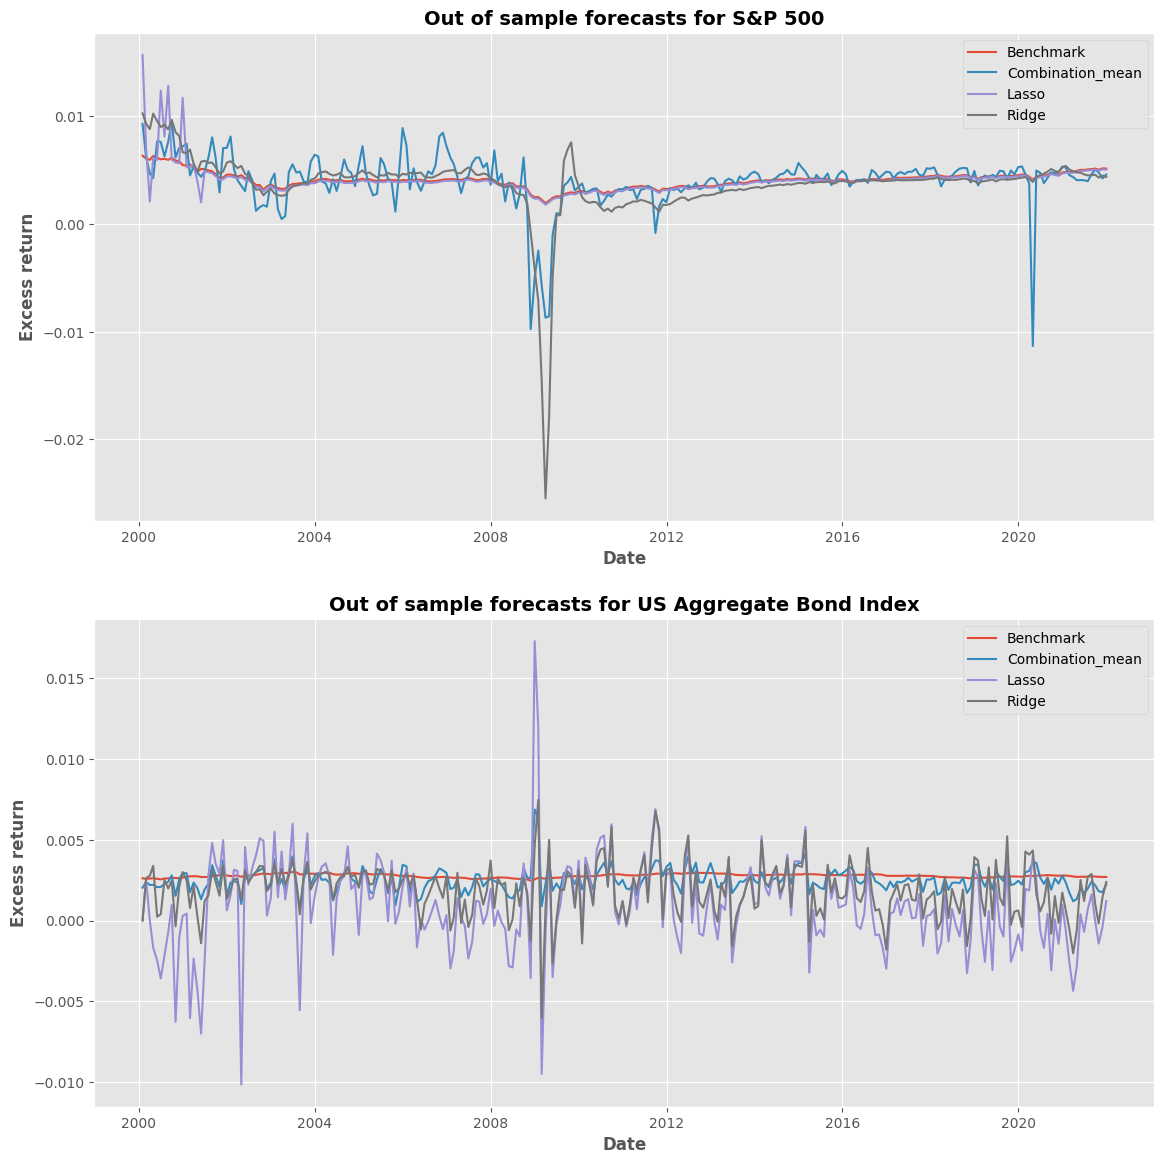

In [10]:
plt.figure(figsize=(12, 12))
desired_models = ['Benchmark', 'Combination_mean', 'Lasso', 'Ridge']

plt.subplot(2, 1, 1)
plt.plot(sp500_all_models.index, sp500_all_models.loc[:, desired_models].values)
plt.title(f'Out of sample forecasts for S&P 500', fontweight='bold', fontsize=14)
plt.xlabel('Date', weight='bold', fontsize=12)
plt.ylabel('Excess return', weight='bold', fontsize=12)
plt.legend(desired_models)

plt.subplot(2, 1, 2)
plt.plot(bond_all_models.index, bond_all_models.loc[:, desired_models].values)
plt.title(f'Out of sample forecasts for US Aggregate Bond Index', fontweight='bold', fontsize=14)
plt.xlabel('Date', weight='bold', fontsize=12)
plt.ylabel('Excess return', weight='bold', fontsize=12)
plt.legend(desired_models)

plt.tight_layout(pad=2.0)
plt.show()

---

    Q4. Generate the out-of-sample forecasts of the (2-by-2) sample variance-covariance matrix for a portfolio of the two asset classes using the same recursive estimation window approach.

In [11]:
portf_cov_mat_forecasts_df = generate_portfolio_var_cov_mat_forecast(excess_ret=simp_ret_df.loc[:, ['SP500_excess', 'LBUSTRUU_excess']], 
                                                                      breakpoint=breakpoint)
print('Out-of-sample variance-covariance matrix forecasts')
print('-' * 100)
portf_cov_mat_forecasts_df

Out-of-sample variance-covariance matrix forecasts
----------------------------------------------------------------------------------------------------


,portf_asset_cov_mat
Date,
2000-01-31,"[[0.0018897584149084586, 0.0002524624546616479..."
2000-02-29,"[[0.0018974827403917516, 0.0002539505897946499..."
2000-03-31,"[[0.0018934439259658826, 0.0002522391216037861..."
2000-04-28,"[[0.0019161207421885755, 0.000253281314824986]..."
2000-05-31,"[[0.0019153547473805433, 0.0002539603937952528..."
...,...
2021-08-31,"[[0.0018946570307722132, 0.0001095848772087840..."
2021-09-30,"[[0.0018920043554343543, 0.0001091436659901349..."
2021-10-29,"[[0.0018937613885882897, 0.0001101220860134556..."


---

    Q5. Using the mean benchmark excess return forecasts and sample variance-covariance matrix forecasts, construct out-of-sample optimal tangency portfolio weights for a mean-variance investor. Compute the annualized summary statistics (mean, volatility, and Sharpe ratio) for the optimal portfolio’s excess return. Repeat the exercise with the 8 predictive model excess return forecasts in place of the mean benchmark excess return forecasts and compute the annualized summary statistics for the alternative optimal portfolio’s excess return.
    
    Report the summary statistics in a table and explain the results. Does any statistical evidence of out-of-sample forecasting performance translate into economic gains/significance? In addition, create a figure showing the time-series of portfolio weights and cumulative excess returns for the optimal portfolio based on the mean benchmark forecast and those based on the combination and penalized linear regression excess return forecasts

In [12]:
# placeholder for storing list of individual DFs with asset return forecasts computed using all the models
temp_list = [pd.concat([sp500_all_models.iloc[:, i], bond_all_models.iloc[:, i]], axis=1) for i in range(len(sp500_all_models.columns))]
# placeholder for OTP excess return (for all model forecasts) 
otp_excess_ret_all_models = pd.DataFrame(index=sp500_all_models.index, 
                                         columns=['Benchmark', 'OLS_1', 'OLS_2', 'OLS_3', 'OLS_4', 'OLS_5', 'CM', 'PLR_1', 'PLR_2'])
# placeholder for OTP out-of-sample weights (for all model forecasts)
otp_ofs_weights_all_models = otp_excess_ret_all_models.copy()
for i in range(len(temp_list)):
    # compute time-series of monthly OTP excess return for all the forecast models
    otp_excess_ret_all_models.iloc[:, i], otp_ofs_weights_all_models.iloc[:, i] = generate_OTP_excess_ret(temp_list[i], portf_cov_mat_forecasts_df)
print('OTP out-of-sample excess returns (all 9 predictive models)')
print('-' * 100)
otp_excess_ret_all_models

OTP out-of-sample excess returns (all 9 predictive models)
----------------------------------------------------------------------------------------------------


,Benchmark,OLS_1,OLS_2,OLS_3,OLS_4,OLS_5,CM,PLR_1,PLR_2
Date,,,,,,,,,
2000-01-31,0.003161,0.006053,0.003720,0.002925,0.001124,0.002979,0.003299,0.009817,0.002517
2000-02-29,0.003081,0.003464,0.003547,0.001660,0.003874,0.002656,0.003039,0.005388,0.004232
2000-03-31,0.003081,0.001097,0.003542,0.002098,0.004076,0.002730,0.002622,0.001298,0.004218
2000-04-28,0.003142,-0.000537,0.003764,0.001162,0.005362,0.003075,0.002548,0.003138,0.005001
2000-05-31,0.003079,0.005377,0.003621,0.000753,0.001878,0.003000,0.003008,0.002730,0.002436
...,...,...,...,...,...,...,...,...,...
2021-08-31,0.002984,0.002083,0.002810,0.002305,0.004364,0.002079,0.002678,0.002892,0.003138
2021-09-30,0.002981,0.003259,0.002804,0.002317,0.002420,0.002110,0.002530,0.001884,0.001595
2021-10-29,0.002948,0.002947,0.002733,0.002215,0.001148,0.002076,0.002175,0.000974,0.000540


In [13]:
# Compute Portfolio excess return summary statistics 
portf_excess_ret_summary_stats = pd.DataFrame(index=['Mean', 'Volatility', 'Sharpe', 'Skew', 'Kurtosis'], 
                                              columns=otp_excess_ret_all_models.columns)
for i in range(len(portf_excess_ret_summary_stats.columns)):
    portf_excess_ret_summary_stats.iloc[:, i] = compute_stat_measures(otp_excess_ret_all_models.iloc[:, i].values)
print('OTP out-of-sample excess returns summary statistics (all 9 predictive models)')
print('-' * 100)
portf_excess_ret_summary_stats

OTP out-of-sample excess returns summary statistics (all 9 predictive models)
----------------------------------------------------------------------------------------------------


,Benchmark,OLS_1,OLS_2,OLS_3,OLS_4,OLS_5,CM,PLR_1,PLR_2
Mean,0.035150,0.042704,0.032356,0.020753,0.035456,0.034168,0.032746,0.028424,0.026787
Volatility,0.000388,0.007607,0.001240,0.006997,0.007047,0.001887,0.002343,0.005609,0.005108
Sharpe,90.652244,5.613941,26.089881,2.965820,5.031319,18.111165,13.973403,5.067566,5.244033
Skew,-1.254039,0.780646,-0.284264,-6.622554,-0.325889,1.910303,-0.049942,0.701168,-1.664958
Kurtosis,5.389226,6.081003,5.081652,54.664853,5.031053,12.689666,4.688920,7.394199,11.336551


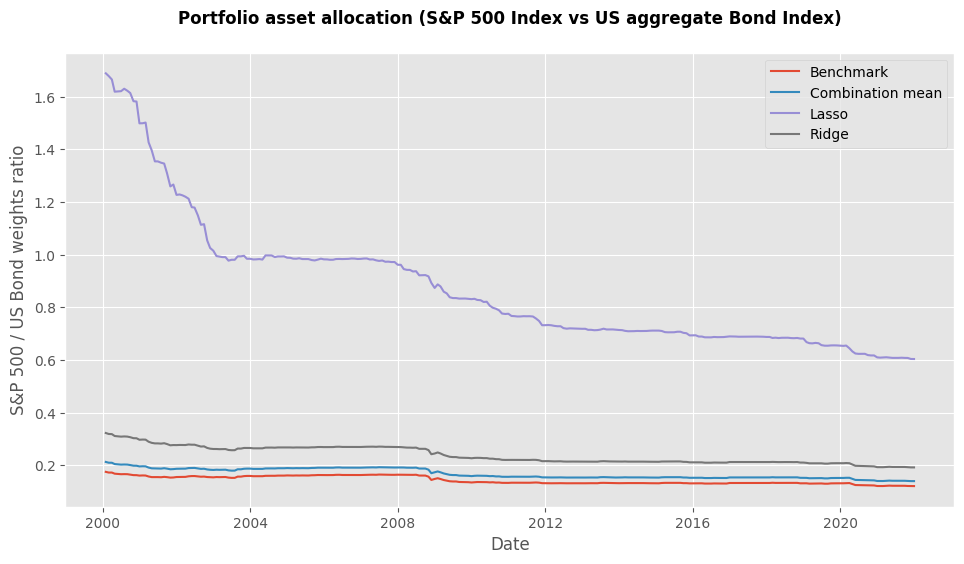

In [14]:
# Plot portfolio asset allocation for various forecast models
plt.figure(figsize=(10, 6))
plt.title(f"Portfolio asset allocation (S&P 500 Index vs US aggregate Bond Index)\n", fontweight='bold', fontsize=12)
plt.plot(otp_ofs_weights_all_models.index, [x[0]/x[1] for x in otp_ofs_weights_all_models['Benchmark'].values], label='Benchmark')
plt.plot(otp_ofs_weights_all_models.index, [x[0]/x[1] for x in otp_ofs_weights_all_models['CM'].values], label='Combination mean')
plt.plot(otp_ofs_weights_all_models.index, [x[0]/x[1] for x in otp_ofs_weights_all_models['PLR_1'].values], label='Lasso')
plt.plot(otp_ofs_weights_all_models.index, [x[0]/x[1] for x in otp_ofs_weights_all_models['PLR_2'].values], label='Ridge')
plt.ylabel("S&P 500 / US Bond weights ratio")
plt.xlabel("Date")
plt.tight_layout(pad=2.0)
plt.legend(loc='best')

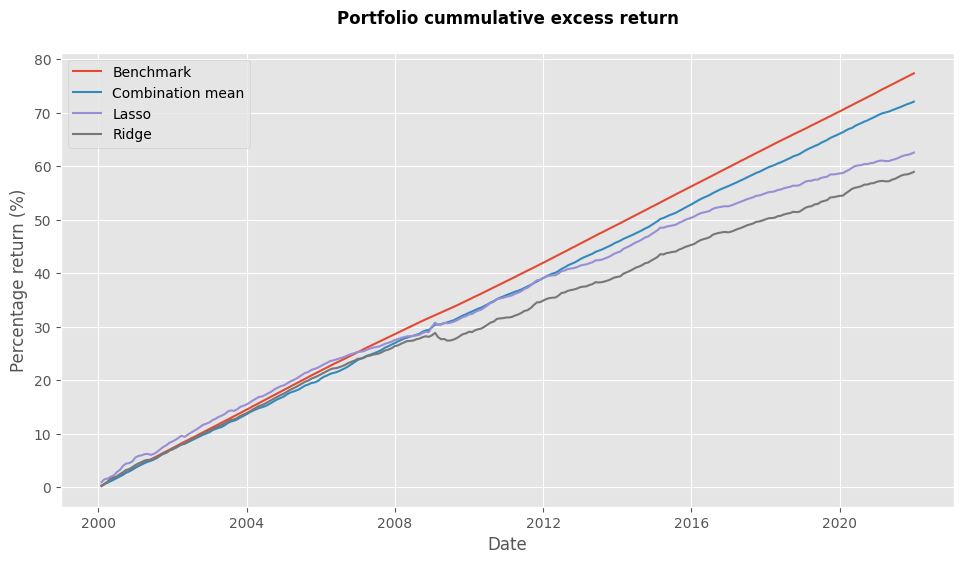

In [15]:
# Plot portfolio daily and cummulative returns for various forecast models
plt.figure(figsize=(10, 6))
plt.title(f"Portfolio cummulative excess return\n", fontweight='bold', fontsize=12)
plt.plot(otp_excess_ret_all_models.index, otp_excess_ret_all_models['Benchmark'].cumsum() * 100, label='Benchmark')
plt.plot(otp_excess_ret_all_models.index, otp_excess_ret_all_models['CM'].cumsum() * 100, label='Combination mean')
plt.plot(otp_excess_ret_all_models.index, otp_excess_ret_all_models['PLR_1'].cumsum() * 100, label='Lasso')
plt.plot(otp_excess_ret_all_models.index, otp_excess_ret_all_models['PLR_2'].cumsum() * 100, label='Ridge')
plt.ylabel("Percentage return (%)")
plt.xlabel("Date")
plt.tight_layout(pad=2.0)
plt.legend(loc='best')

---